## Librerias

In [1]:
import pandas as pd
import numpy as np
from google.cloud import bigquery
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# Deshabilitar el modo interactivo
plt.ioff()

## Funciones

In [2]:
class Graficador:

    def __init__(self):
        pass

    def create_subplots_one_var(self,data, n_rows, n_cols, graph, fig_size = (30,25)):
        # Indices de la grilla de graficos de matplotlib
        i = 0
        j = 0

        # Creacion de la grilla de graficos
        fig, axes = plt.subplots(nrows = n_rows, ncols = n_cols, figsize = fig_size)

        for column in data.columns:

            # Creacion del grafico de barras
            graph(data = data[[column]], ax = axes[i,j])

            # Se añade el titulo a la grafica
            axes[i,j].set_title(f'{column}')

            # Indices para poder ir agregando los graficos
            j += 1
            if j > n_cols - 1:
                j = 0
                i+=1

        return fig, axes

    def create_subplots_one_var_group(self, data, n_rows, n_cols, graph, fig_size = (30,25)):
        # Indices de la grilla de graficos de matplotlib
        i = 0
        j = 0

        # Creacion de la grilla de graficos
        fig, axes = plt.subplots(nrows = n_rows, ncols = n_cols, figsize = fig_size)
        data_temp = data[::]
        data_temp['temp'] = 0
        for column in data_temp.columns:
            
            if column == 'temp':
                continue

            temp = data_temp[[column, 'temp']].groupby(column, as_index = False).count().rename(columns = {'temp' : 'Conteo'})
            # Creacion del grafico de barras
            graph(data = temp, x = column, y = 'Conteo', ax = axes[i,j])

            # Se añade el titulo a la grafica
            axes[i,j].set_title(f'{column}')

            # Indices para poder ir agregando los graficos
            j += 1
            if j > n_cols - 1:
                j = 0
                i+=1

        return fig, axes

def create_apilated_bars(data):

    grupos = data.columns

    fig, ax = plt.subplots()
    values = data.values

    for i in range(values.shape[0]):
        ax.bar(grupos, values[i], bottom = np.sum(values[:i], axis = 0), label = data.index[i])
        # Agregar títulos a los ejes

    return fig,ax


def outlier_label(value, limit):
    if value < limit[0]:
        return 'Abajo'
    elif value > limit[1]:
        return 'Arriba'
    else:
        return 'No'

def take_outliers(data, variable):
    Q1 = data[variable].quantile(0.25)
    Q3 = data[variable].quantile(0.75)
    RIC = Q3 - Q1
    limit_inf = Q1 - (1.5 * RIC)
    limit_sup = Q3 + (1.5 * RIC)
    data[f'{variable}_outlier'] = data[variable].apply(lambda x: outlier_label(x, [limit_inf,limit_sup]))
    return data

## Parametros

In [3]:
client_bq = bigquery.Client()

In [4]:
table = 'Diabetes_avicena_survival.diabetes_final'

variables_with_outliers = ['edad','IMC','HDL','LDL','trigliceridos','perimetro_abdominal']

numeric_columns = ['edad','IMC','HDL','LDL','trigliceridos','perimetro_abdominal','time_to_event']
categoric_columns = ['genero_paciente','raza_paciente','nivel_academico_paciente','ant_cardio','med_hipertension','ant_familiar_dm','hace_ejercicio']
target = 'diabetes'

In [5]:
graficador = Graficador()

## Proceso

In [6]:
data = client_bq.query(f'SELECT * FROM {table}').result().to_dataframe()
print(f'Se trajo {data.shape} datos de pacientes')
data.head()

Se trajo (9032, 21) datos de pacientes


,numero_identificacion_paciente,year,month,fecha,edad,peso,talla,IMC,HDL,LDL,...,perimetro_abdominal,genero_paciente,raza_paciente,nivel_academico_paciente,ant_cardio,med_hipertension,ant_familiar_dm,hace_ejercicio,diabetes,time_to_event
0,26151819,2022,8,2022-08-01,70,82.0,1.59,32.435425814,45.3,158.0,...,96.0,Femenino,Mestizo,Bachillerato técnico,1,0,0,20 minutos,0,1
1,1007107070,2022,8,2022-08-01,19,56.0,1.61,21.604104780,56.0,99.0,...,75.0,Femenino,Otros,Básica secundaria,0,0,0,Nunca,1,1
2,34341427,2024,1,2024-01-01,39,78.0,1.60,30.468750000,64.5,102.0,...,89.5,Femenino,Otros,Tecnológica,0,0,0,40 minutos,0,1
3,94426911,2024,1,2024-01-01,50,91.0,1.75,29.714285714,38.0,150.8,...,95.0,Masculino,Mestizo,Básica secundaria,0,0,0,Nunca,0,1
4,43524938,2024,1,2024-01-01,56,56.0,1.55,23.309053070,51.0,143.4,...,74.5,Femenino,Otros,Técnica profesional,0,0,0,20 minutos,0,1


In [7]:
## Cantidad de pacientes con diabetes
data[['numero_identificacion_paciente','diabetes']].drop_duplicates().groupby('diabetes', as_index = False).count()

,diabetes,numero_identificacion_paciente
0,0,7520
1,1,1512


In [14]:
# Dataframe con los datos numericos
df_numerico = data[numeric_columns]
df_numerico['IMC'] = np.round(df_numerico['IMC'].astype(float),2)

df_numerico.head()

,edad,IMC,HDL,LDL,trigliceridos,perimetro_abdominal,time_to_event
0,70,32.44,45.3,158.0,238.0,96.0,1
1,19,21.60,56.0,99.0,95.0,75.0,1
2,39,30.47,64.5,102.0,162.1,89.5,1
3,50,29.71,38.0,150.8,211.0,95.0,1
4,56,23.31,51.0,143.4,254.7,74.5,1


In [9]:
# Dataframe con los datos categoricos
df_categorico = data[categoric_columns + [target]].astype(str)

df_categorico.head()

,genero_paciente,raza_paciente,nivel_academico_paciente,ant_cardio,med_hipertension,ant_familiar_dm,hace_ejercicio,diabetes
0,Femenino,Mestizo,Bachillerato técnico,1,0,0,20 minutos,0
1,Femenino,Otros,Básica secundaria,0,0,0,Nunca,1
2,Femenino,Otros,Tecnológica,0,0,0,40 minutos,0
3,Masculino,Mestizo,Básica secundaria,0,0,0,Nunca,0
4,Femenino,Otros,Técnica profesional,0,0,0,20 minutos,0


## Outliers

In [15]:
data_label = data.copy()
data_label['IMC'] = np.round(data_label['IMC'].astype(float),2)

In [16]:
for variable in variables_with_outliers:
    print(variable)
    data_label = take_outliers(data_label, variable)

edad
IMC
HDL
LDL
trigliceridos
perimetro_abdominal


In [17]:
for variable in variables_with_outliers:
    print(variable)
    conteos = data_label[f'{variable}_outlier'].value_counts().reset_index()
    total = conteos['count'].sum()
    conteos['Porcentaje'] = (conteos['count'] / total)*100
    display(conteos)

edad


,edad_outlier,count,Porcentaje
0,No,9029,99.966785
1,Arriba,3,0.033215


IMC


,IMC_outlier,count,Porcentaje
0,No,8793,97.353853
1,Arriba,228,2.524358
2,Abajo,11,0.121789


HDL


,HDL_outlier,count,Porcentaje
0,No,8796,97.387068
1,Arriba,233,2.579717
2,Abajo,3,0.033215


LDL


,LDL_outlier,count,Porcentaje
0,No,8907,98.616032
1,Arriba,119,1.317538
2,Abajo,6,0.066430


trigliceridos


,trigliceridos_outlier,count,Porcentaje
0,No,8665,95.93667
1,Arriba,367,4.06333


perimetro_abdominal


,perimetro_abdominal_outlier,count,Porcentaje
0,No,8873,98.239593
1,Arriba,131,1.450399
2,Abajo,28,0.310009


In [18]:
columns_to_drop = [column + '_outlier' for column in variables_with_outliers]

data_clean_outliers = data_label[(data_label.edad_outlier == 'No') &
                                 (data_label.IMC_outlier == 'No') &
                                 (data_label.HDL_outlier == 'No') &
                                 (data_label.LDL_outlier == 'No') &
                                 (data_label.trigliceridos_outlier == 'No') &
                                 (data_label.perimetro_abdominal_outlier == 'No')
                                ]

data_clean_outliers = data_clean_outliers.drop(columns = columns_to_drop)

data_clean_outliers

,numero_identificacion_paciente,year,month,fecha,edad,peso,talla,IMC,HDL,LDL,...,perimetro_abdominal,genero_paciente,raza_paciente,nivel_academico_paciente,ant_cardio,med_hipertension,ant_familiar_dm,hace_ejercicio,diabetes,time_to_event
0,26151819,2022,8,2022-08-01,70,82.0,1.59,32.44,45.3,158.0,...,96.0,Femenino,Mestizo,Bachillerato técnico,1,0,0,20 minutos,0,1
1,1007107070,2022,8,2022-08-01,19,56.0,1.61,21.60,56.0,99.0,...,75.0,Femenino,Otros,Básica secundaria,0,0,0,Nunca,1,1
2,34341427,2024,1,2024-01-01,39,78.0,1.60,30.47,64.5,102.0,...,89.5,Femenino,Otros,Tecnológica,0,0,0,40 minutos,0,1
3,94426911,2024,1,2024-01-01,50,91.0,1.75,29.71,38.0,150.8,...,95.0,Masculino,Mestizo,Básica secundaria,0,0,0,Nunca,0,1
4,43524938,2024,1,2024-01-01,56,56.0,1.55,23.31,51.0,143.4,...,74.5,Femenino,Otros,Técnica profesional,0,0,0,20 minutos,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9027,28833810,2022,1,2022-01-01,81,79.6,1.48,36.34,42.3,142.0,...,111.0,Femenino,Otros,Básica primaria,1,1,0,Nunca,0,36
9028,72249308,2022,1,2022-01-01,42,85.0,1.70,29.41,36.1,97.2,...,101.0,Masculino,Otros,Profesional,1,1,0,Nunca,0,36
9029,25654517,2022,1,2022-01-01,72,58.1,1.48,26.52,30.6,80.0,...,84.0,Femenino,Otros,Tecnológica,1,1,0,20 minutos,0,36
9030,24166911,2022,1,2022-01-01,62,52.0,1.57,21.10,72.0,91.0,...,74.0,Femenino,Otros,Básica secundaria,1,1,0,20 minutos,0,36


In [32]:
data_clean_outliers = data_clean_outliers.drop(columns = ['peso','talla'])
data_clean_outliers

,numero_identificacion_paciente,year,month,fecha,edad,IMC,HDL,LDL,trigliceridos,perimetro_abdominal,genero_paciente,raza_paciente,nivel_academico_paciente,ant_cardio,med_hipertension,ant_familiar_dm,hace_ejercicio,diabetes,time_to_event
0,26151819,2022,8,2022-08-01,70,32.44,45.3,158.0,238.0,96.0,Femenino,Mestizo,Bachillerato técnico,1,0,0,20 minutos,0,1
1,1007107070,2022,8,2022-08-01,19,21.60,56.0,99.0,95.0,75.0,Femenino,Otros,Básica secundaria,0,0,0,Nunca,1,1
2,34341427,2024,1,2024-01-01,39,30.47,64.5,102.0,162.1,89.5,Femenino,Otros,Tecnológica,0,0,0,40 minutos,0,1
3,94426911,2024,1,2024-01-01,50,29.71,38.0,150.8,211.0,95.0,Masculino,Mestizo,Básica secundaria,0,0,0,Nunca,0,1
4,43524938,2024,1,2024-01-01,56,23.31,51.0,143.4,254.7,74.5,Femenino,Otros,Técnica profesional,0,0,0,20 minutos,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9027,28833810,2022,1,2022-01-01,81,36.34,42.3,142.0,198.0,111.0,Femenino,Otros,Básica primaria,1,1,0,Nunca,0,36
9028,72249308,2022,1,2022-01-01,42,29.41,36.1,97.2,156.0,101.0,Masculino,Otros,Profesional,1,1,0,Nunca,0,36
9029,25654517,2022,1,2022-01-01,72,26.52,30.6,80.0,304.0,84.0,Femenino,Otros,Tecnológica,1,1,0,20 minutos,0,36
9030,24166911,2022,1,2022-01-01,62,21.10,72.0,91.0,81.0,74.0,Femenino,Otros,Básica secundaria,1,1,0,20 minutos,0,36


In [33]:
data_clean_outliers.to_csv('datas_no_outliers.csv', sep = '|', index = False)

## One Variable

In [20]:
## informacion de la data
df_numerico.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9032 entries, 0 to 9031
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   edad                 9032 non-null   Int64  
 1   IMC                  9032 non-null   float64
 2   HDL                  9032 non-null   float64
 3   LDL                  9032 non-null   float64
 4   trigliceridos        9032 non-null   float64
 5   perimetro_abdominal  9032 non-null   float64
 6   time_to_event        9032 non-null   Int64  
dtypes: Int64(2), float64(5)
memory usage: 511.7 KB


In [21]:
## Descripcion de los datos
df_numerico.describe()

,edad,IMC,HDL,LDL,trigliceridos,perimetro_abdominal,time_to_event
count,9032.0,9032.000000,9032.000000,9032.000000,9032.000000,9032.000000,9032.0
mean,58.749668,28.493924,48.339194,113.124161,154.497476,93.998659,15.493357
std,15.297366,5.421452,13.099490,40.410622,95.801076,12.890284,9.588589
min,18.0,13.780000,11.000000,0.000000,1.280000,30.000000,1.0
25%,48.0,24.930000,39.200000,84.800000,98.675000,85.458333,7.0
50%,60.0,27.870000,46.600000,111.000000,134.000000,94.000000,15.0
75%,69.0,31.310000,55.000000,137.270000,186.000000,102.000000,23.0
max,102.0,138.120000,198.900000,640.500000,2124.000000,160.000000,36.0


Grafico de distribuciones


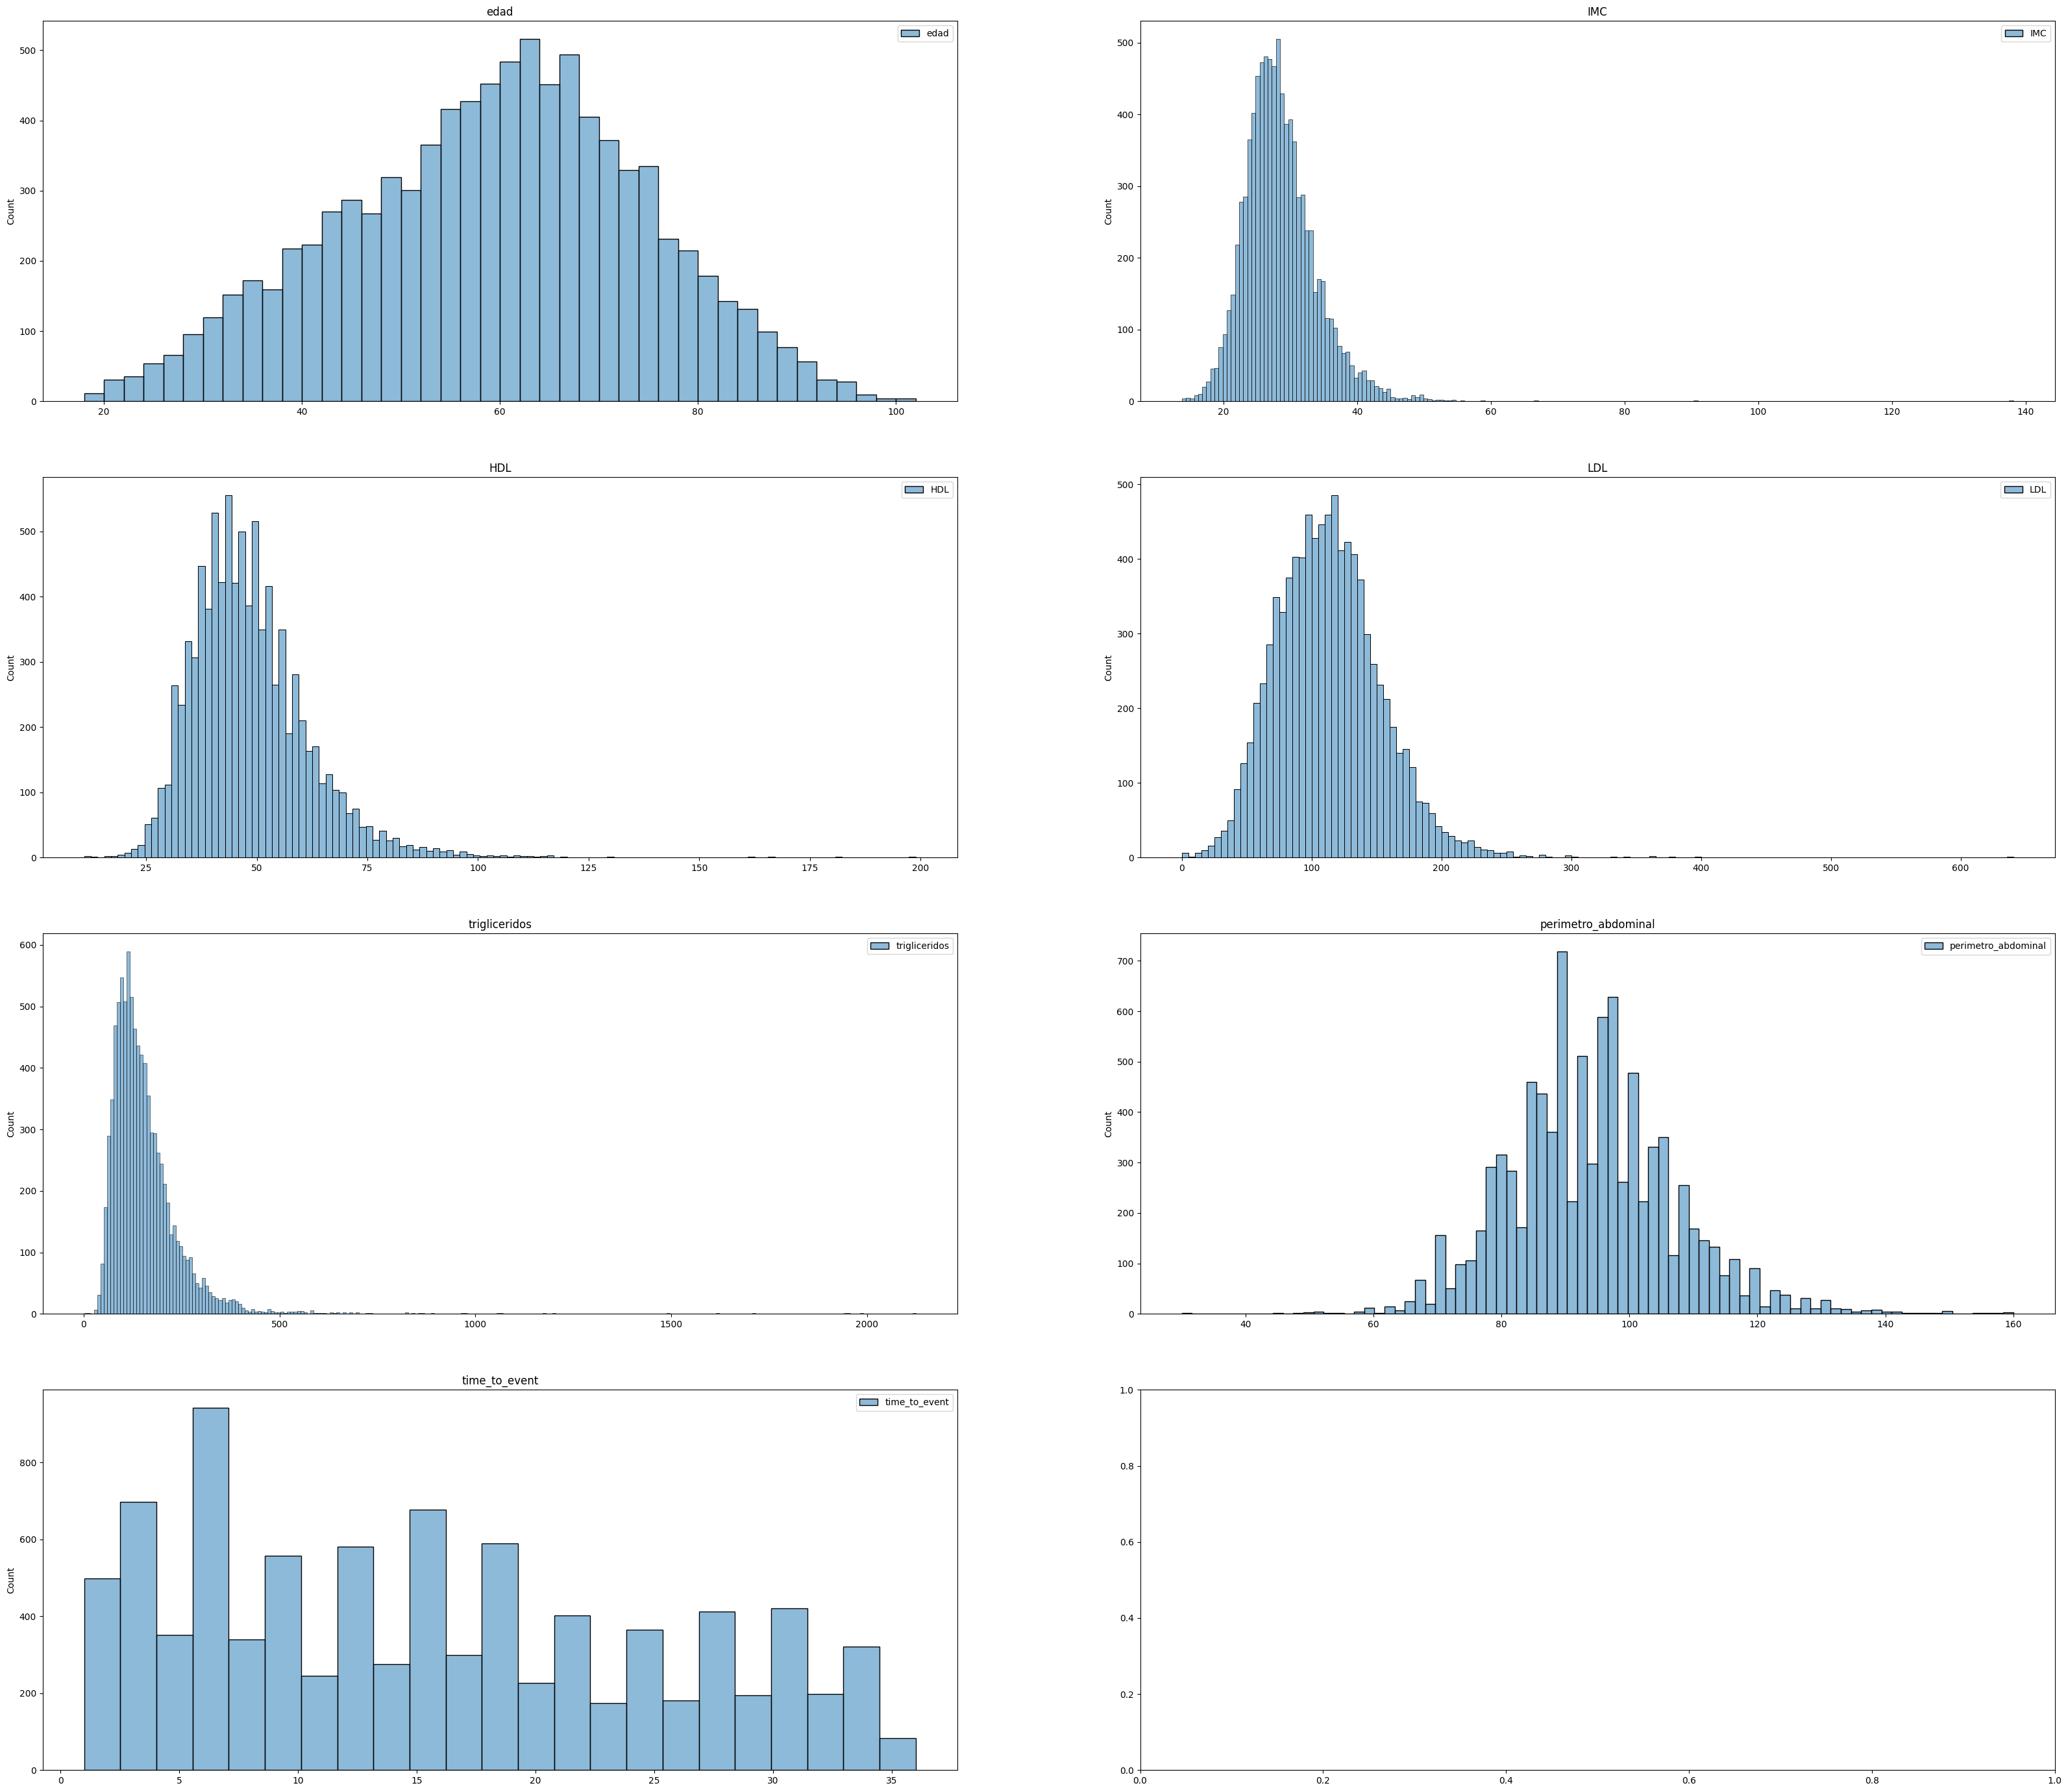

In [22]:
print('Grafico de distribuciones')
fig, axes = graficador.create_subplots_one_var(data = df_numerico, n_cols = 2, n_rows = 4, graph= sns.histplot, fig_size = (40,35))
plt.show()

Grafico de caja y bigotes


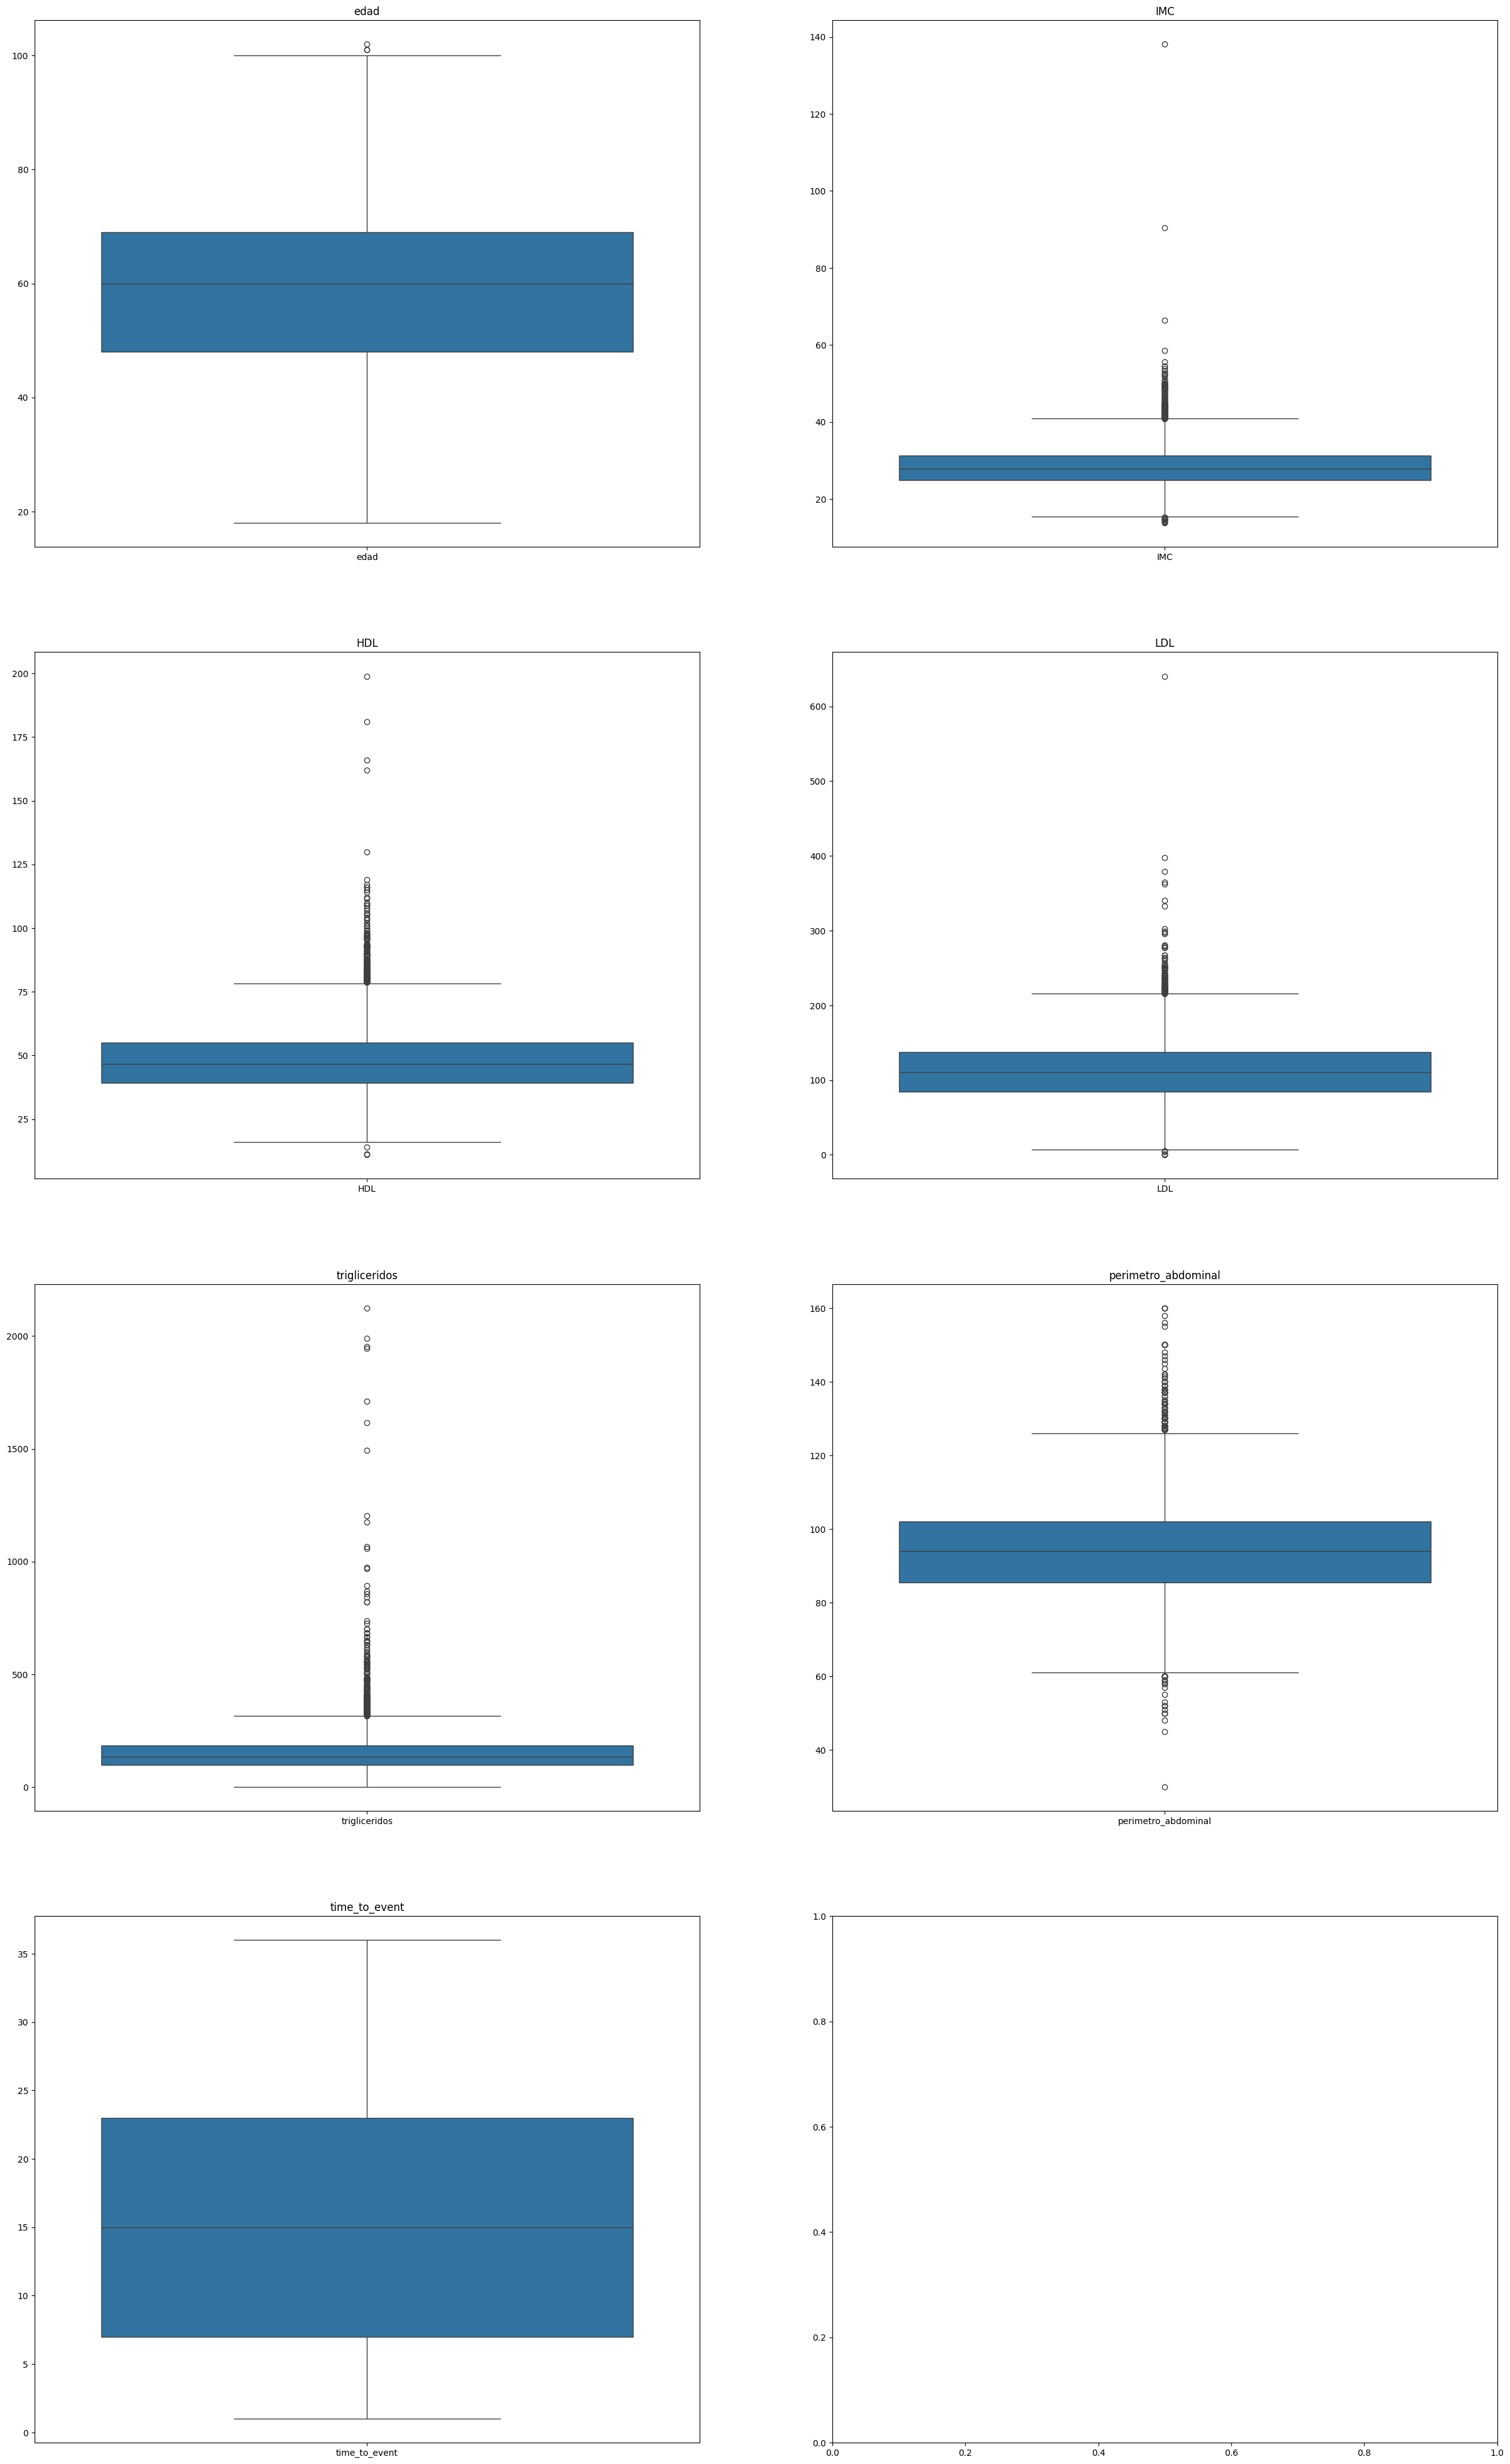

In [23]:
print('Grafico de caja y bigotes')
fig, axes = graficador.create_subplots_one_var(data = df_numerico, n_cols = 2, n_rows = 4, graph= sns.boxplot, fig_size=(30,50))
plt.show()

In [24]:
df_categorico.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9032 entries, 0 to 9031
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   genero_paciente           9032 non-null   object
 1   raza_paciente             9032 non-null   object
 2   nivel_academico_paciente  9032 non-null   object
 3   ant_cardio                9032 non-null   object
 4   med_hipertension          9032 non-null   object
 5   ant_familiar_dm           9032 non-null   object
 6   hace_ejercicio            9032 non-null   object
 7   diabetes                  9032 non-null   object
dtypes: object(8)
memory usage: 564.6+ KB


Conteos de cada una de las categorias


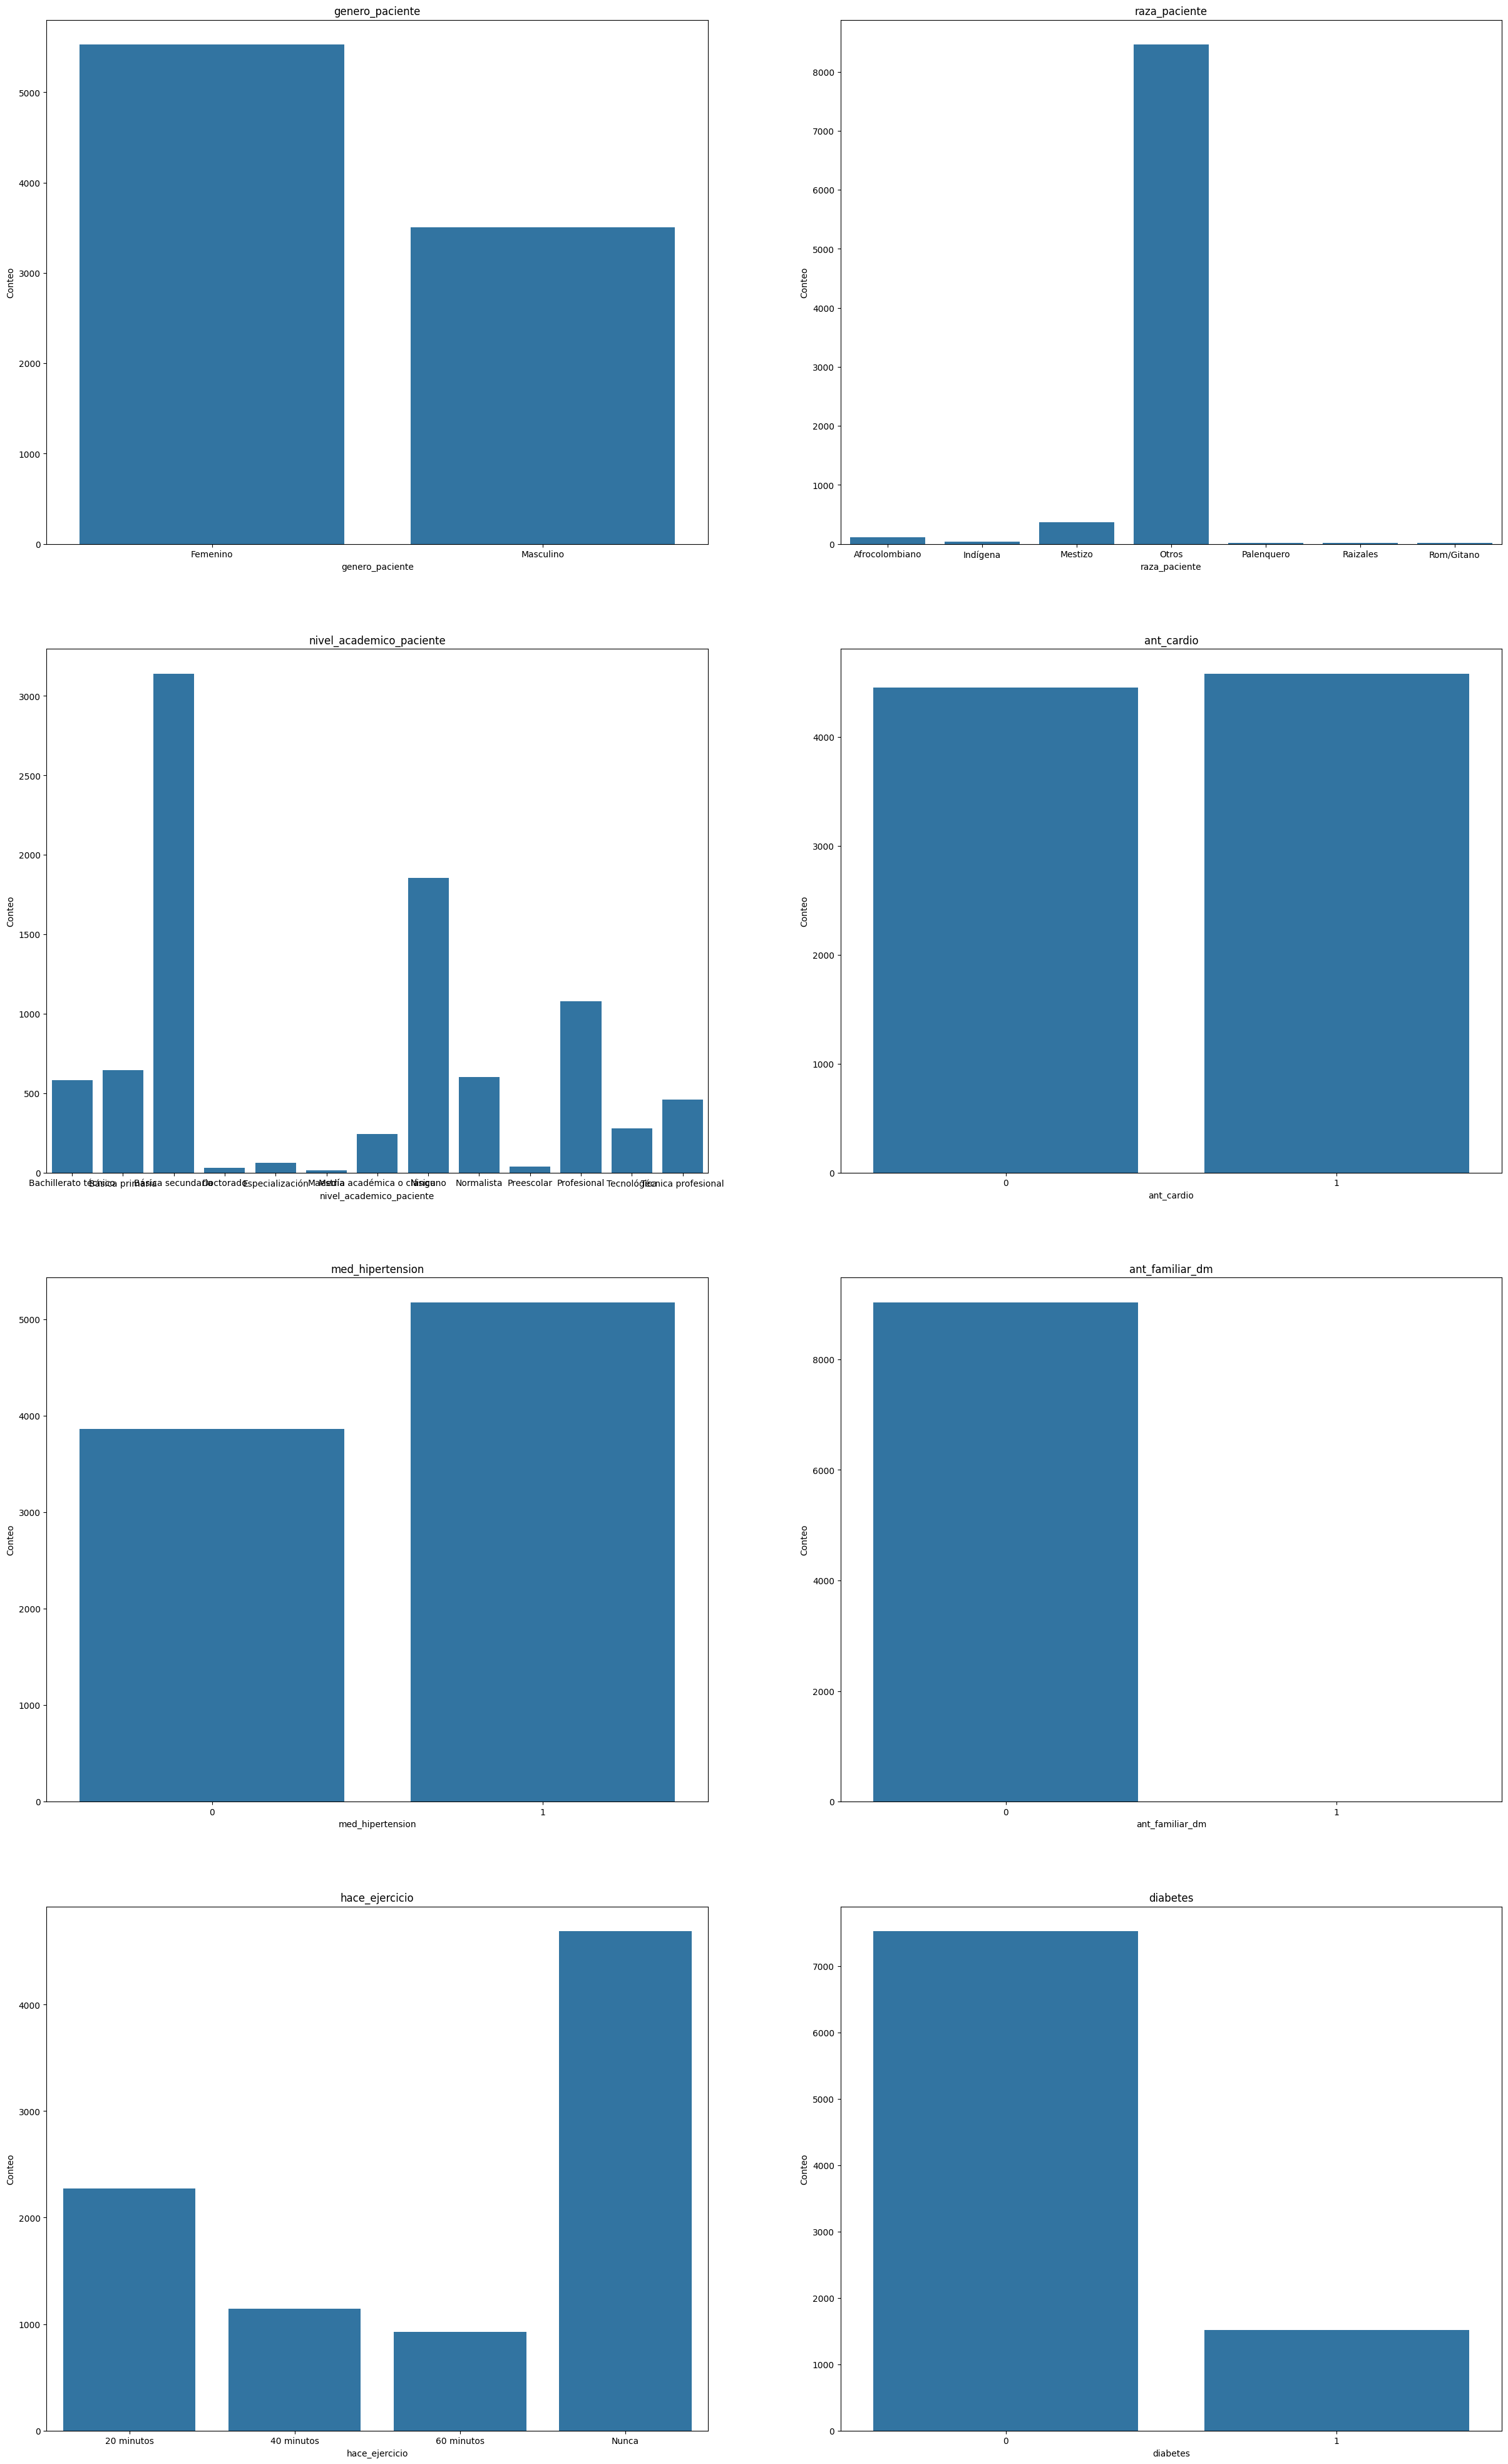

In [25]:
print('Conteos de cada una de las categorias')
fig, axes = graficador.create_subplots_one_var_group(data = df_categorico, n_cols = 2, n_rows = 4, graph= sns.barplot, fig_size=(30,50))
plt.show()

## Two Variables

Grafico de dispersion para cada par de variables


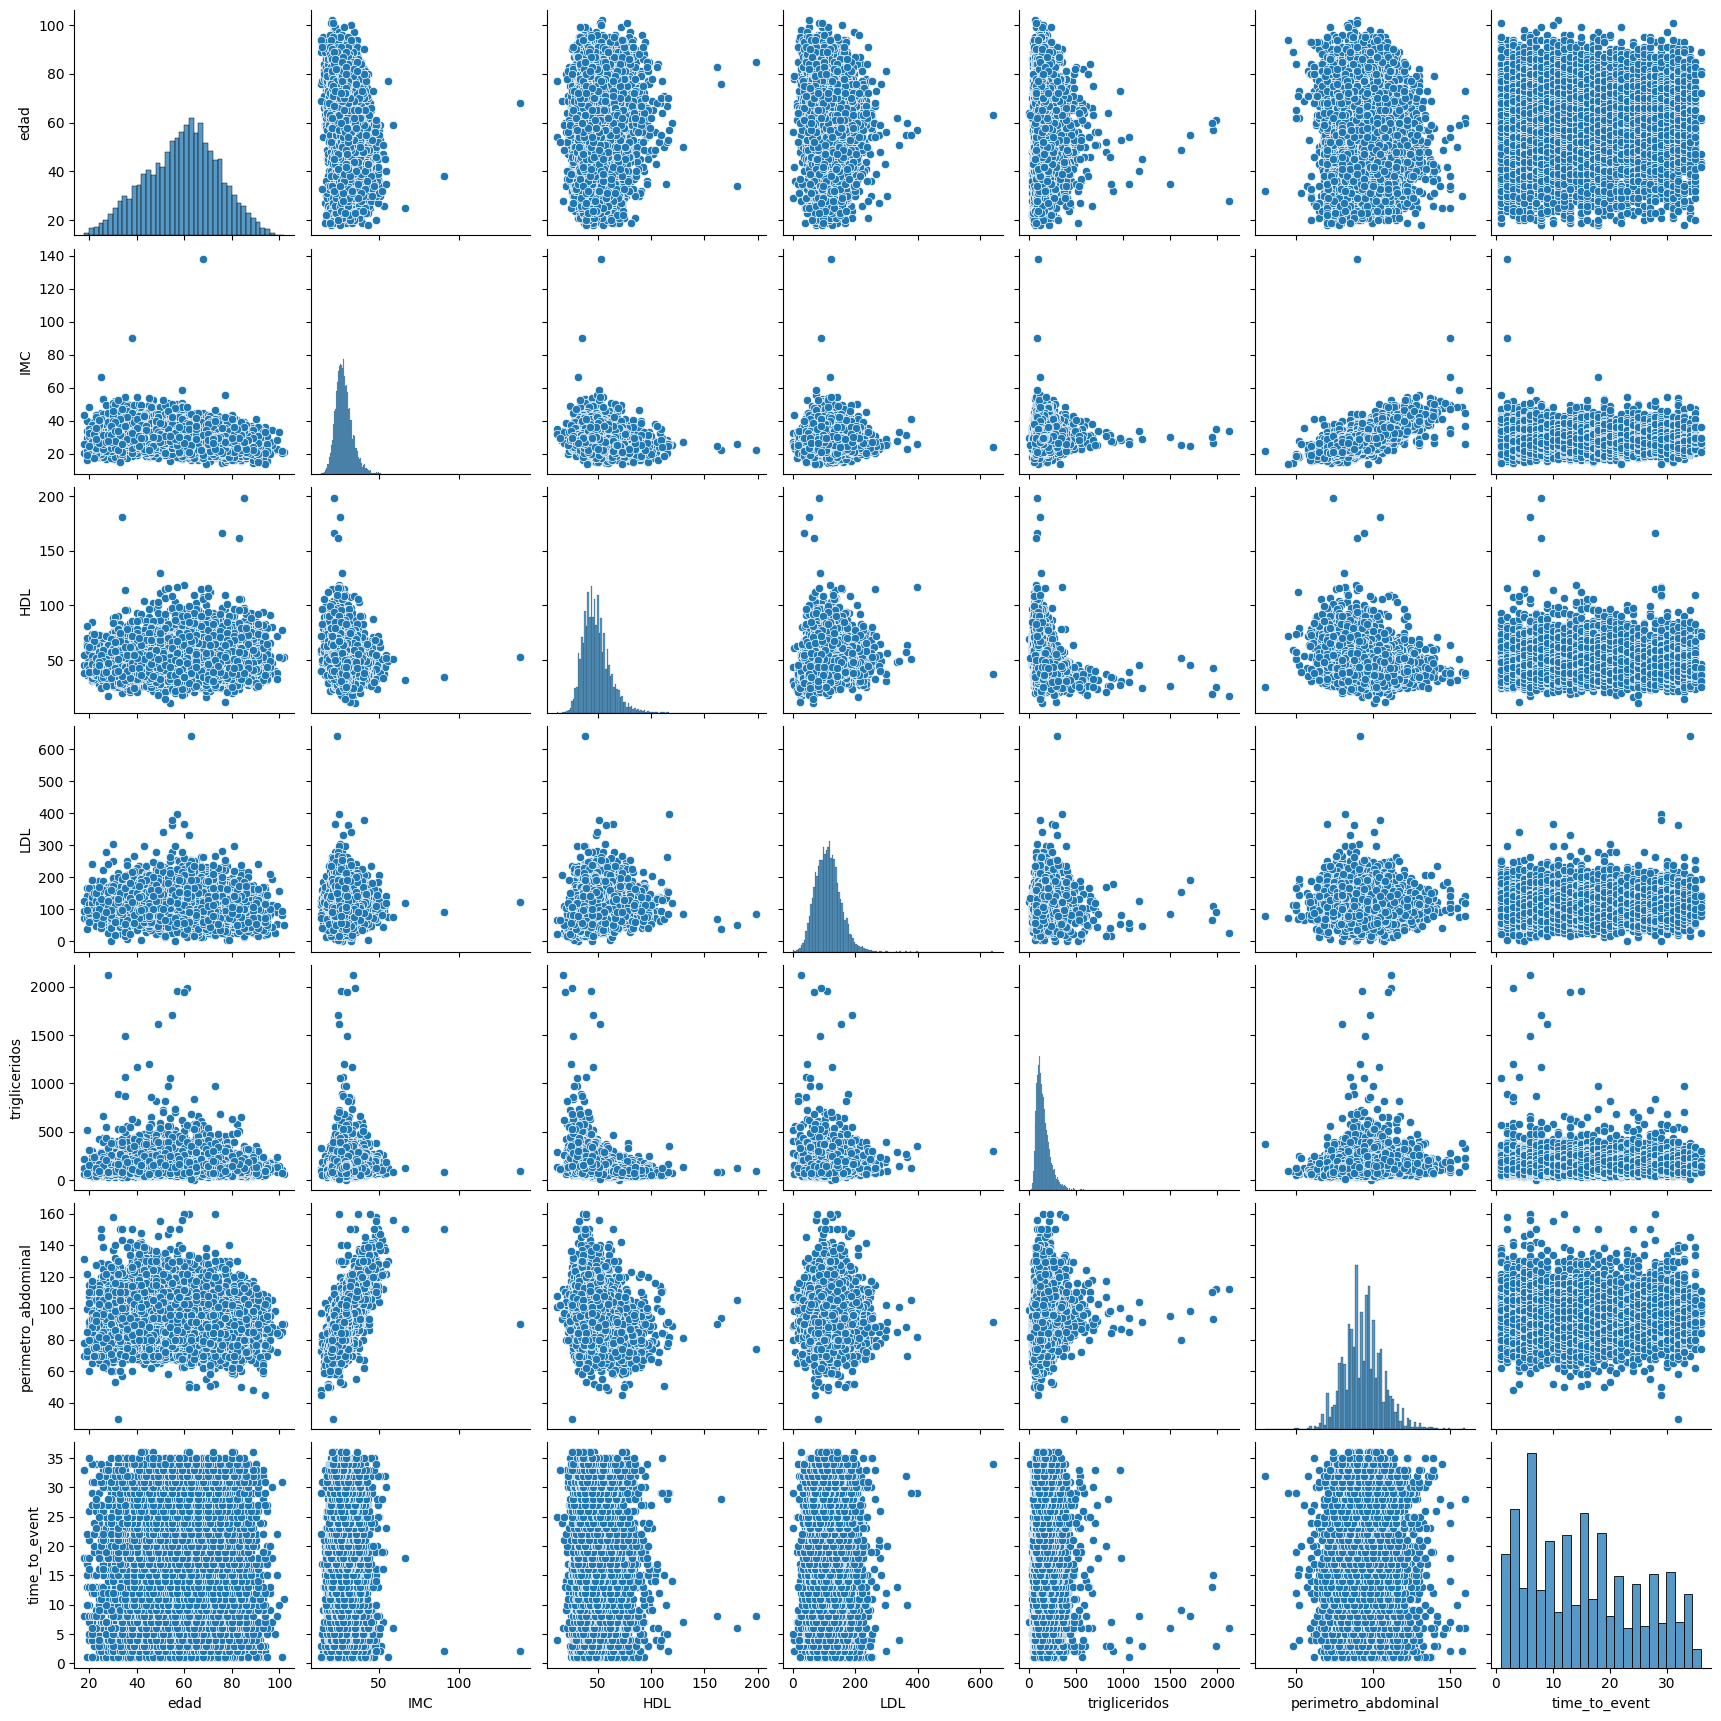

In [26]:
print('Grafico de dispersion para cada par de variables')
sns.pairplot(df_numerico)

In [31]:
print('Matriz de correlaciones')
px.imshow(np.round(df_numerico.corr(),2), text_auto=True, height=500, width=700)

Matriz de correlaciones


In [28]:
print('Matriz de covarianza')
df_numerico.cov()

Matriz de covarianza


,edad,IMC,HDL,LDL,trigliceridos,perimetro_abdominal,time_to_event
edad,234.009412,-18.289022,24.348932,-66.582797,-67.806205,-4.816294,4.699865
IMC,-18.289022,29.392142,-14.643171,-0.199648,67.025616,49.840124,-0.714333
HDL,24.348932,-14.643171,171.596635,48.771248,-445.799620,-45.293455,0.792139
LDL,-66.582797,-0.199648,48.771248,1633.018389,171.403890,-28.729168,2.701659
trigliceridos,-67.806205,67.025616,-445.799620,171.403890,9177.846107,190.535096,-3.656004
perimetro_abdominal,-4.816294,49.840124,-45.293455,-28.729168,190.535096,166.159414,2.308103
time_to_event,4.699865,-0.714333,0.792139,2.701659,-3.656004,2.308103,91.941048


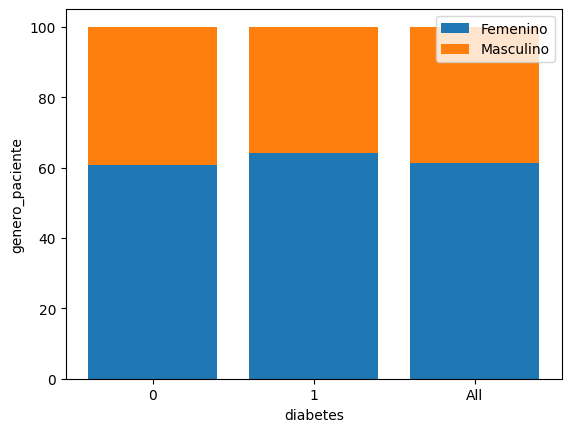

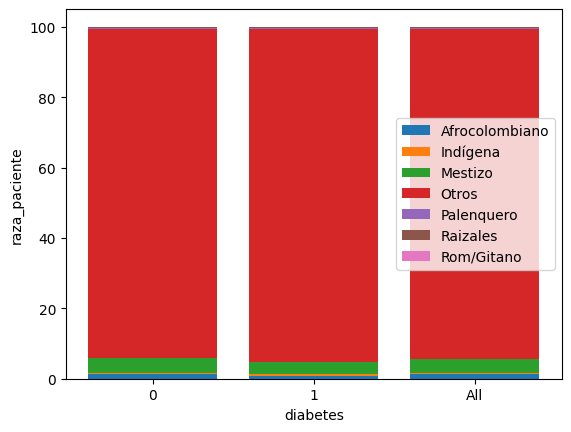

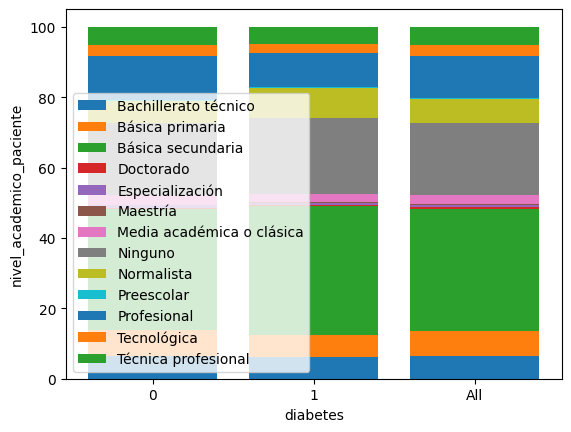

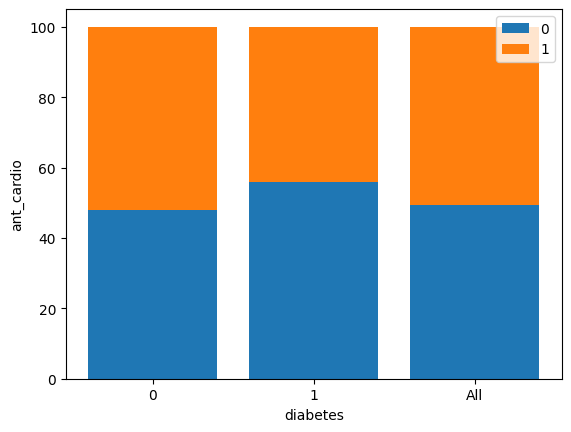

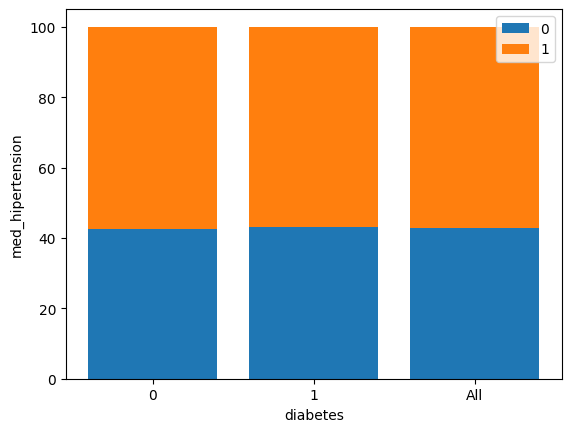

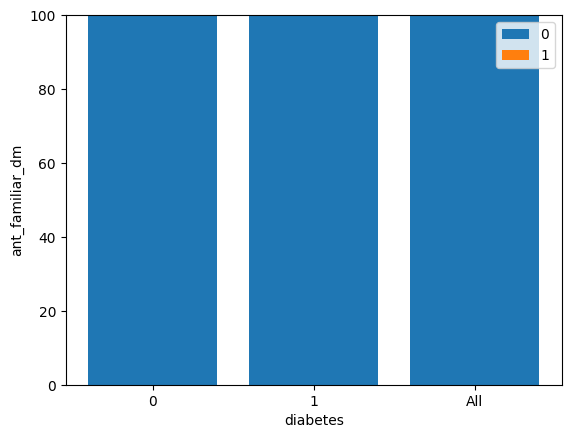

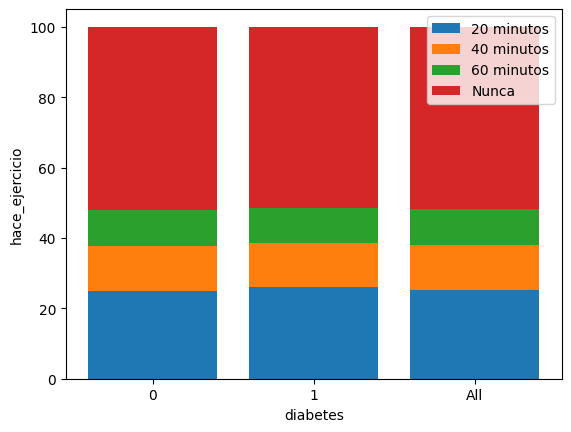

In [29]:
var2 = 'diabetes'

for column in df_categorico.columns:

    if column == var2:
        continue

    # Filtrar el df
    df_temp = df_categorico[[column,var2]][::]

    # Columna temporal para el conteo de los datos
    df_temp['temp'] = 0

    # Convertir a tipo str para la grafica
    df_temp.columns = df_temp.columns.astype(str)

    # Crear tabla de contingencia
    pivot = pd.pivot_table(df_temp, values = 'temp', index = column, columns = var2, aggfunc = 'count', margins = True)
    
    # Crear tabla con el perfil columna
    pc = round((pivot/ pivot.loc['All'].values)*100,2).iloc[:-1]

    # Crear grafico de barras apiladas del perfil columna
    fig, ax = create_apilated_bars(pc)
    ax.set_xlabel(var2)
    ax.set_ylabel(column)
    plt.legend()


plt.show()

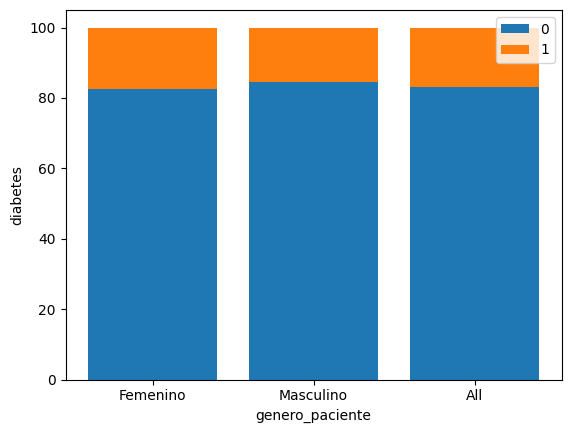

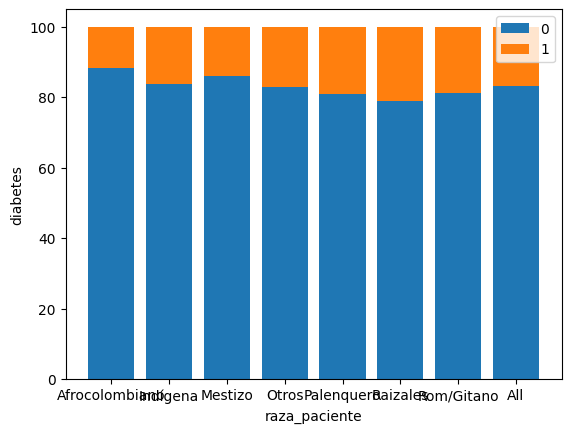

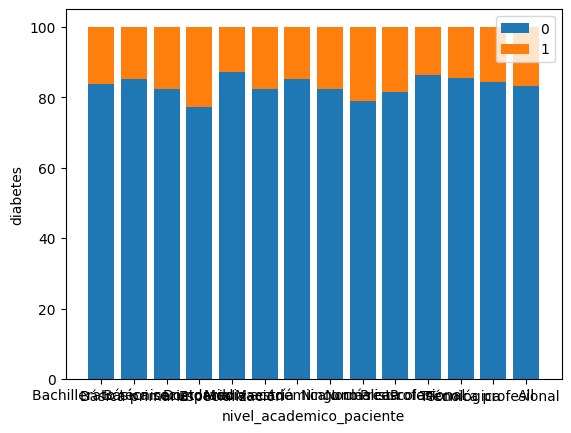

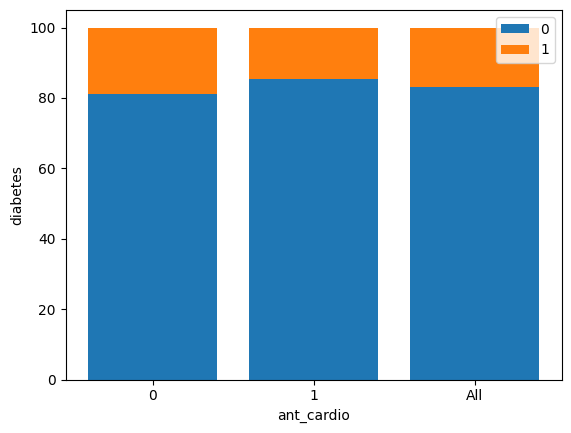

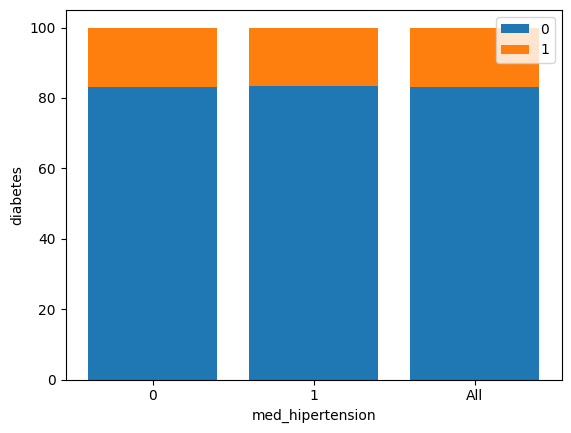

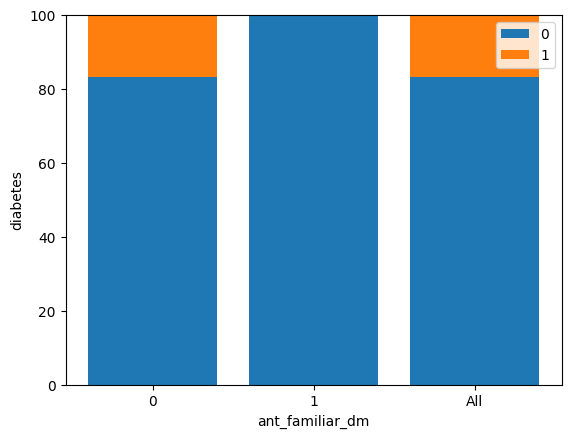

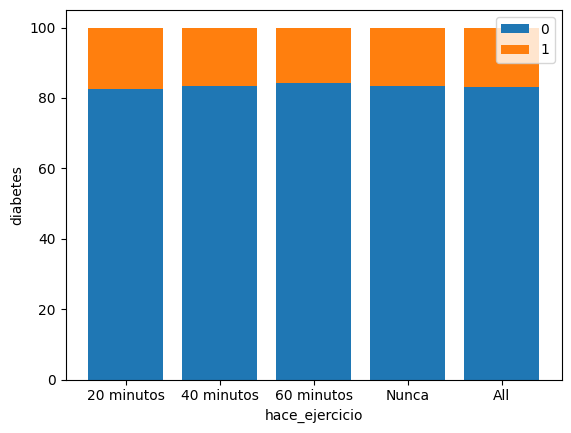

In [30]:
var2 = 'diabetes'

for column in df_categorico.columns:

    if column == var2:
        continue

    # Filtrar el df
    df_temp = df_categorico[[column,var2]][::]

    # Columna temporal para el conteo de los datos
    df_temp['temp'] = 0

    # Convertir a tipo str para la grafica
    df_temp.columns = df_temp.columns.astype(str)

    # Crear tabla de contingencia
    pivot = pd.pivot_table(df_temp, values = 'temp', index = column, columns = var2, aggfunc = 'count', margins = True)
    # Crear tabla con el perfil columna
    pf = round((pivot.T/ pivot.loc[:,'All'].values)*100,2).iloc[:-1]

    # Crear grafico de barras apiladas del perfil columna
    fig, ax = create_apilated_bars(pf)
    ax.set_xlabel(column)
    ax.set_ylabel(var2)
    plt.legend()


plt.show()